In [2]:
from carmm.run.workflows.react_mace import ReactMACE
from ase.build import molecule, add_adsorbate
from ase.optimize import FIRE
from ase.neb import NEB
import numpy as np

MODEL_SIZE = "medium"

PARAMS = {'model': MODEL_SIZE,
          'dispersion': False,
          'default_dtype': 'float64',
          'device': 'cpu'}

def setup_optimiser(images, method = "aseneb", precon=None, optimizer=FIRE, optmethod=None):
    
  from ase.optimize.fire import FIRE
    
  'Code mostly adapted from unit test for test_precon_neb.py in ASE'
    
  if precon == 'Exp' or 'Exp_FF':
    k = 0.0001
  else:
    k = 0.1

  mep = NEB(images, k=k, method=method, precon=precon, climb=True, parallel=False, allow_shared_calculator=False)
  mep.interpolate(method="idpp", mic=True, apply_constraint=True)
  #mep.idpp_interpolate(traj='idpp.traj', log='idpp.log', fmax=0.1, optimizer=FIRE, mic=True, steps=100)

  if optmethod is not None:
    opt = optimizer(mep, method=optmethod)
  else:
    opt = optimizer(mep)

  return opt, mep

def print_path_info_to_json(out_dict, method, optimizer, optmethod, precon):

  import json

  with open(f'pathinfo.json', 'w') as filout:
    json.dump(out_dict, filout)

def setup_path(initial, final, n_images):
  from mace.calculators import mace_mp

  images = [initial]
  for i in range(n_images):
    image = initial.copy()
    images.append(image)

  images.append(final)

  for i in range(len(images)):
    images[i].calc = mace_mp(**PARAMS)

  return images

def opt_image(image, filename):
  reactor = ReactMACE(PARAMS, force_field="mace_mp", filename=filename)
  reactor.mace_optimise(image, fmax=0.02)

  return reactor.model_optimised

def run_neb_method(initial, final, n_images, calc_name, head_dir, method, optimizer, optmethod, precon):
  from ase.neb import NEBTools, NEB
  from ase.utils.forcecurve import fit_images
  import shutil
  import os

  def save_fmax_history(mep, fmax_history):
    fmax_history.append(mep.get_residual())

  cwd = os.getcwd()

  testdir_name = f'{calc_name}_MEP_{method}_{optimizer.__name__}_{optmethod}_{precon}'
  head_dir = head_dir
  testdir = os.path.join(head_dir, testdir_name)

  if os.path.exists(testdir):
    shutil.rmtree(testdir, ignore_errors=True)

  os.mkdir(testdir)
  os.chdir(testdir)

  initial = opt_image(initial, 'initial')
  final = opt_image(final, 'final')

  images = setup_path(initial, final, n_images)

  opt, mep = setup_optimiser(images, method=method, optimizer=optimizer, optmethod=optmethod, precon=precon)

  fmax_history = []
  opt.attach(save_fmax_history, 1, mep, fmax_history)

  opt.run(fmax=2e-2, steps=200)

  nebtools = NEBTools(images)
  Ef, dE = nebtools.get_barrier(fit=False)

  forcefit = fit_images(images)

  outdict = {"fmax_history": fmax_history, "nsteps": len(fmax_history), 'method': method, 'optmethod': optmethod,
             "precon": precon, "optimizer": optimizer.__name__, "path": forcefit.path,
             "energies": forcefit.energies.tolist(), "fit_path": forcefit.fit_energies.tolist(),
             "fit_energies": forcefit.fit_energies.tolist(), "lines": np.array(forcefit.lines).tolist(),
             "Ef": Ef, "dE": dE}

  print_path_info_to_json(outdict, method, optimizer, optmethod, precon)

  os.chdir(cwd)

In [16]:
def get_fresh_slab(fmax):
    '''Build the React_Aims object using the set of settings'''
    from ase.build import bulk, surface
    from carmm.build.neb.symmetry import sort_z
    from ase.constraints import FixAtoms

    reactor = ReactMACE(PARAMS)
    '''Prepare the Atoms object geometry'''

    '''Calculate bulk energy'''
    reactor.filename = f"Pd_bulk_{MODEL_SIZE}"
    bulk_geometry = bulk("Pd", a=3.89)
    bulk_geometry = reactor.mace_optimise(bulk_geometry, fmax=fmax, relax_unit_cell=True, restart=True)

    '''Calculate pristine surface slab energy'''
    reactor.filename = f"Pd_111_{MODEL_SIZE}"
    slab = surface(bulk_geometry, (1, 1, 1), 7, vacuum=20)
    slab = slab.repeat((3, 3, 1))
    slab = sort_z(slab, diff=1)
    constraint = FixAtoms(indices=[atom.index for atom in slab if atom.tag > 4])
    slab.set_constraint([constraint])

    return slab


def get_chemisorption(fmax):
    name = f"CO2_chemisorbed_{MODEL_SIZE}"
    slab = get_fresh_slab(fmax)
    adsorbate = molecule("CO2")
    adsorbate.rotate(90, (1,0,0))
    adsorbate.rotate(30, (0,0,1))
    add_adsorbate(slab, adsorbate, position=(slab[-1].position[:2]), height=1.3)

    return slab

def get_physisorption(fmax):
    name = f"CO2_physisorbed_{MODEL_SIZE}"
    slab = get_fresh_slab(fmax)
    adsorbate = molecule("CO2")
    adsorbate.rotate(90, (1,0,0))
    adsorbate.rotate(30, (0,0,1))
    add_adsorbate(slab, adsorbate, position=(slab[-1].position[:2]), height=3)

    return slab

In [3]:
from ase.neb import NEBOptimizer
from ase.optimize.fire import FIRE
from ase.io import read
import os

test_dir = '/home/gabriellbramley/TS_Algorithms_Comparison'
os.chdir(test_dir)

#initial = get_physisorption(0.02)
#final = get_chemisorption(0.02)
initial = read("ML-NEB.traj",index=0)
final = read("ML-NEB.traj",index=-1)

test_params = [["aseneb", FIRE, None, None]]
#test_params = [["spline", NEBOptimizer, "ODE", "Exp"], ["spline", NEBOptimizer, "ODE", None]]

#run_neb_method(initial, final, 5, calc_name='SMS-migration', head_dir=test_dir, method="string", optimizer=NEBOptimizer, optmethod="ODE", precon="Exp")
for params in test_params:
    run_neb_method(initial, final, 5, calc_name='SMS-migration-medium-5im', head_dir=test_dir, method=params[0], optimizer=params[1], optmethod=params[2], precon=params[3])

Structure is converged.
Structure is converged.
Using Materials Project MACE for MACECalculator with /home/gabriellbramley/.cache/mace/5yyxdm76
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /home/gabriellbramley/.cache/mace/5yyxdm76
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /home/gabriellbramley/.cache/mace/5yyxdm76
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /home/gabriellbramley/.cache/mace/5yyxdm76
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /home/gabriellbramley/.cache/mace/5yyxdm76
Using float64 for MACECalculator, which 

['SMS-migration-medium-5im_MEP_spline_NEBOptimizer_ODE_None']: de 0.9878041549012551, Ef: 1.5000512161295774, nsteps 178
['SMS-migration-medium-5im_MEP_spline_NEBOptimizer_ODE_Exp']: de 1.0372014958081763, Ef: 1.4733206812360322, nsteps 173


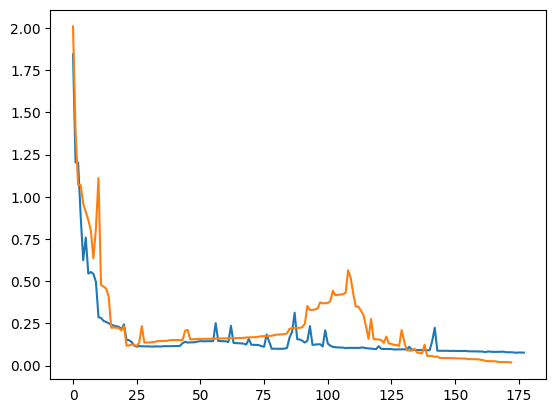